# 1. Boosting Algorithm

- 여러개의 (약한)분류기가 순차적으로 학습을 하면서, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해<br/>다음 분류기가 가중치를 인가해서 학습을 이어 진행하는 방식
- 예측 성능이 뛰어나 앙상블 학습을 주도하고 있음
- 그래디언 부스트, XGBoost(eXtra Gradient Boost), LightGBM(Light Gradient Boost) 등이 있음
    - GBM(Gradient Boosting Machine): AdaBoost기법과 비슷하지만, 가중치를 업데이트 할 때 경사하강법(Gradient Descent)을 사용
    - XGBoost(eXtra Gradient Boost): GBM에서 PC의 파워를 효율적으로 사용하기 위한 다양한 기법에 채택되어 빠른 속도와 효율을 가짐
    - LightGBM(Light Gradient Boost): XGBoost보다 속도가 빠름


#### < 배깅와 부스팅의 차이 >
- 배깅 : 샘플링한 데이터를 한번에 모델에 돌려서, 결과를 한번에 병렬적으로 얻음
- 부스팅 : **"데이터 학습 > 결과 > 모델 튜닝(가중치 설정 등) > 재학습"** 의 순서로 순차적으로 진행됨

#### < 앙상블 기법 >
- 앙상블은 전통적으로 Voting, Bagging, Boosting, 스태깅 등으로 나눔
- 보팅과 배깅은 여러개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식
- 보팅과 배깅의 차이점은 보팅은 각각 다른 분류기, 배깅은 같은 분류기를 사용
- 대표적인 배깅 방식이 Random Forest

### (1) 데이터 불러오기

In [1]:
import pandas as pd

wine_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/wine.csv"

wine = pd.read_csv(wine_url, index_col=0)
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,color
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1


In [2]:
wine['taste'] = [1. if grade>5 else 0. for grade in wine['quality']]

X = wine.drop(['taste', 'quality'], axis=1)
y = wine['taste']

### (2) StandardScaler() 적용 & 데이터 분할

In [4]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_sc = sc.fit_transform(X)

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_sc, y, test_size=0.2, random_state=13)

### (3) 특성 확인

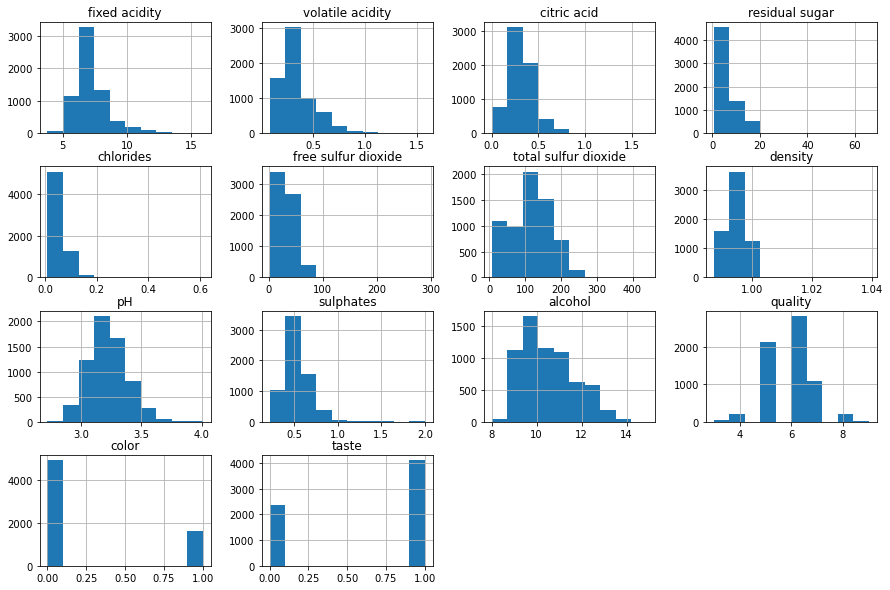

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

wine.hist(bins=10, figsize=(15, 10))
plt.show()

- 잘 분포되어 있는 컬럼이 좋은 경우가 많다.

In [9]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'color', 'taste'],
      dtype='object')

In [11]:
# quality별 다른 특성들이 어떤지 확인

col_names = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
             'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
             'pH', 'sulphates', 'alcohol']
df_pivot_table = wine.pivot_table(col_names, ['quality'], aggfunc='median')
df_pivot_table

,alcohol,chlorides,citric acid,density,fixed acidity,free sulfur dioxide,pH,residual sugar,sulphates,total sulfur dioxide,volatile acidity
quality,,,,,,,,,,,
3,10.15,0.0550,0.33,0.995900,7.45,17.0,3.245,3.15,0.505,102.5,0.415
4,10.00,0.0505,0.26,0.994995,7.00,15.0,3.220,2.20,0.485,102.0,0.380
5,9.60,0.0530,0.30,0.996100,7.10,27.0,3.190,3.00,0.500,127.0,0.330
6,10.50,0.0460,0.31,0.994700,6.90,29.0,3.210,3.10,0.510,117.0,0.270
7,11.40,0.0390,0.32,0.992400,6.90,30.0,3.220,2.80,0.520,114.0,0.270
8,12.00,0.0370,0.32,0.991890,6.80,34.0,3.230,4.10,0.480,118.0,0.280
9,12.50,0.0310,0.36,0.990300,7.10,28.0,3.280,2.20,0.460,119.0,0.270


- 눈에 보이는게 없음..ㅎ

In [12]:
# quality와 다른 특성 간 상관관계 확인

corr_matrix = wine.corr()
print(corr_matrix['quality'].sort_values(ascending=False))

quality                 1.000000
taste                   0.814484
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
color                  -0.119323
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


- alcohol, density 가 중요!

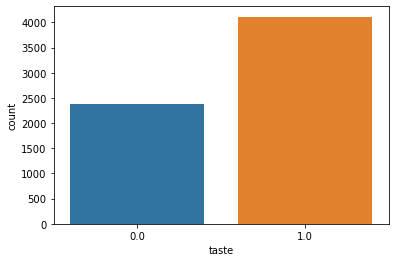

In [18]:
# taste 컬럼의 분포 확인

import seaborn as sns

sns.countplot(wine['taste'])
plt.show();

### (4) 다른 모델들을 한번에 테스트

In [22]:
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

models = []
models.append(("RandomForestClassifier", RandomForestClassifier()))
models.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
models.append(("AdaBoostClassifier", AdaBoostClassifier()))
models.append(("GradientBoostingClassifier", GradientBoostingClassifier()))
models.append(("LogisticRegression", LogisticRegression()))

In [23]:
models

[('RandomForestClassifier', RandomForestClassifier()),
 ('DecisionTreeClassifier', DecisionTreeClassifier()),
 ('AdaBoostClassifier', AdaBoostClassifier()),
 ('GradientBoostingClassifier', GradientBoostingClassifier()),
 ('LogisticRegression', LogisticRegression())]

In [25]:
# 모델 사용 (cross-validation)
# validation : 교차검증(train, test 로 분리해서 하는거)
# KFold : K 겹 교차검증
# 지금은 train 데이터만 사용해서 교차검증을 하는 것..!! 
# 여기가 이번 수업에서 가장 중요한 부분!

from sklearn.model_selection import KFold, cross_val_score

res = []
names = []

for name, model in models:
    kfold = KFold(n_splits=5, random_state=13, shuffle=True) # 5겹 폴딩, shuffle: 5등분 전에 데이터를 섞어라
    cv_res = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    res.append(cv_res)
    names.append(name)
    
    print(name, cv_res.mean(), cv_res.std())

RandomForestClassifier 0.8204675353520396 0.015867683804247298
DecisionTreeClassifier 0.7579338491152736 0.0099409597442477
AdaBoostClassifier 0.7533103205745169 0.02644765901536818
GradientBoostingClassifier 0.7667807433182794 0.021938613967147785
LogisticRegression 0.74273191678389 0.015548839626296565


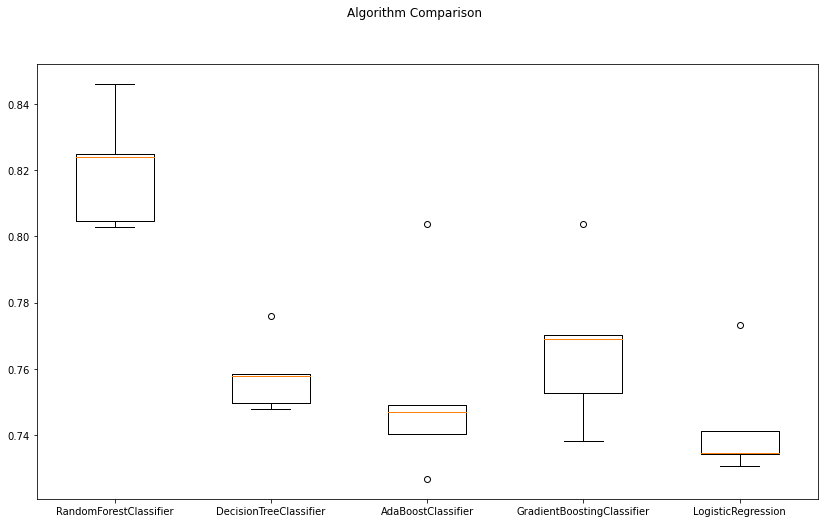

In [26]:
# 결과 확인

fig = plt.figure(figsize=(14, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(res)
ax.set_xticklabels(names)
plt.show()

- 이 그래프로는 RandomForest 가 유리해 보인다.

In [27]:
# 테스트 데이터에 대한 결과 평가

from sklearn.metrics import accuracy_score

for name, model in models:
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print(name, accuracy_score(y_test, pred))

RandomForestClassifier 0.8353846153846154
DecisionTreeClassifier 0.7684615384615384
AdaBoostClassifier 0.7553846153846154
GradientBoostingClassifier 0.7884615384615384
LogisticRegression 0.7469230769230769


- 이번에도  RandomForest 가 유리

---
# 2. k Nearest Neighber(kNN)
- 새로운 데이터가 있을 때, 기존 데이터의 그룹 중 어떤 그룹에 속하는지 분류하는 문제.
- k는 몇 번째 가까운 데이터까지 볼 것인가를 정하는 수치



- 매번 거리를 구해야 한다 - [유클리드 기하] 가 가장 기본
- 단위에 따라 결과가 바뀔 수도 있다 - 표준화 필요


#### < 장단점 >
- 실시간 예측을 위한 학습이 필요하지 않다. > 속도가 빠르다.
- 고차원 데이터에는 적합하지 않다.

## (1) 데이터 불러오기

In [28]:
from sklearn.datasets import load_iris

iris = load_iris()

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, 
                                                    random_state=13, stratify=iris.target)

## (2) kNN 학습

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [31]:
# acc 확인

from sklearn.metrics import accuracy_score

pred = knn.predict(X_test)
print(accuracy_score(y_test, pred))

0.9666666666666667


In [37]:
# 성과 확인

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, pred))

[[10  0  0]
 [ 0  9  1]
 [ 0  0 10]]


```
10  0  0 : 1번 10개 다 1번으로 맞춤
0  9  1 : 2번은 10개 중 9개만 맞추고, 1개는 3번으로 예측
0  0 10 : 3번은 10개 다 3번으로 맞춤
```

In [36]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      0.90      0.95        10
           2       0.91      1.00      0.95        10

    accuracy                           0.97        30
   macro avg       0.97      0.97      0.97        30
weighted avg       0.97      0.97      0.97        30



---
# 3. GBM(Gradient Boosting Machine)
- 부스팅 알고리므은 여러개의 약한 학습기(week learner)를 순차적으로 학습-예측 하면서</br> 잘못 에측한 데이터에 가중치를 부여해 오류를 개선해가는 방식
- GBM은 가중치를 업데이트 할 때 경사 하강법(Gradient Descent)을 이용한다.

## (1) 데이터 읽기

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/features.txt"
feature_name_df = pd.read_csv(url, sep='\s+', header=None, names=['column_index', 'column_name'])
feature_name_df.head()

,column_index,column_name
0,1,tBodyAcc-mean()-X
1,2,tBodyAcc-mean()-Y
2,3,tBodyAcc-mean()-Z
3,4,tBodyAcc-std()-X
4,5,tBodyAcc-std()-Y


In [2]:
feature_name = feature_name_df.iloc[:, 1].values.tolist()
feature_name

['tBodyAcc-mean()-X',
 'tBodyAcc-mean()-Y',
 'tBodyAcc-mean()-Z',
 'tBodyAcc-std()-X',
 'tBodyAcc-std()-Y',
 'tBodyAcc-std()-Z',
 'tBodyAcc-mad()-X',
 'tBodyAcc-mad()-Y',
 'tBodyAcc-mad()-Z',
 'tBodyAcc-max()-X',
 'tBodyAcc-max()-Y',
 'tBodyAcc-max()-Z',
 'tBodyAcc-min()-X',
 'tBodyAcc-min()-Y',
 'tBodyAcc-min()-Z',
 'tBodyAcc-sma()',
 'tBodyAcc-energy()-X',
 'tBodyAcc-energy()-Y',
 'tBodyAcc-energy()-Z',
 'tBodyAcc-iqr()-X',
 'tBodyAcc-iqr()-Y',
 'tBodyAcc-iqr()-Z',
 'tBodyAcc-entropy()-X',
 'tBodyAcc-entropy()-Y',
 'tBodyAcc-entropy()-Z',
 'tBodyAcc-arCoeff()-X,1',
 'tBodyAcc-arCoeff()-X,2',
 'tBodyAcc-arCoeff()-X,3',
 'tBodyAcc-arCoeff()-X,4',
 'tBodyAcc-arCoeff()-Y,1',
 'tBodyAcc-arCoeff()-Y,2',
 'tBodyAcc-arCoeff()-Y,3',
 'tBodyAcc-arCoeff()-Y,4',
 'tBodyAcc-arCoeff()-Z,1',
 'tBodyAcc-arCoeff()-Z,2',
 'tBodyAcc-arCoeff()-Z,3',
 'tBodyAcc-arCoeff()-Z,4',
 'tBodyAcc-correlation()-X,Y',
 'tBodyAcc-correlation()-X,Z',
 'tBodyAcc-correlation()-Y,Z',
 'tGravityAcc-mean()-X',
 'tGravityA

In [13]:
X_train_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/X_train.txt"
X_test_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/X_test.txt"

X_train = pd.read_csv(X_train_url, sep='\s+', header=None)
X_test = pd.read_csv(X_test_url, sep='\s+', header=None)

X_train.columns = feature_name
X_test.columns = feature_name
X_train.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-meanFreq(),fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)"
0,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,-0.934724,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,-0.943068,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,-0.938692,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,-0.938692,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,-0.942469,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892


In [47]:
y_train_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt"
y_test_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt"

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [5]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings

warnings.filterwarnings('ignore')

In [6]:
st = time.time()
gb_clf = GradientBoostingClassifier(random_state=13)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)

print('ACC : ', accuracy_score(y_test, gb_pred))
print('Fit Time : ', time.time() - st)

ACC :  0.9385816084153377
Fit Time :  1043.3071887493134


- 일반적으로 GBM이 성능 자체는 Random Forest보단 좋다고 알려져있다.
- sklearn의 GBM은 속도가 매우 느린 것으로 유명

In [7]:
from sklearn.model_selection import GridSearchCV

params = {'n_estimators' : [100, 500],
         'learning_rate' : [0.05, 0.1]}

st = time.time()
grid = GridSearchCV(gb_clf, param_grid=params, cv=2, verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)
print('Fit Time : ', time.time() - st)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
Fit Time :  8417.139604568481


In [8]:
grid.best_score_

0.9007072905331882

In [9]:
grid.best_params_

{'learning_rate': 0.05, 'n_estimators': 500}

In [10]:
accuracy_score(y_test, grid.best_estimator_.predict(X_test))

0.9392602646759416

- test데이터에 대한 acc까 94%로, 꽤나 높다.

---
# 4. XGBoost
- XGboost는 트리 기반의 앙상블 학습에서 가장 각광받는 알고리즘 중 하나
- GBM 기반의 알고리즘인데, GBM의 느린 속도를 다양한 규제를 통해 해결
- 특히 병렬 학습이 가능하도록 설계됨
- XGBoost는 반복 수행마다 내부적으로 학습데이터와 검증데이터로 교차검증을 수행
- 교차검증을 통해 최적화되면 반복을 중단하는 조기 중단 기능을 갖고 있음
- [관련 페이지](https://machinelearningmastery.com/evaluate-gradient-boosting-models-xgboost-python/)


#### < 주요 파라미터 >
- nthread : CPU의 실행 스레드 개수를 조정. 디폴트는 CPU의 전체 스레드를 사용
- eta : GBM 학습률
- num_boost_rounds : decision tree의 개수. n_estimators와 같은 파라미터
- max_depth

In [11]:
#!pip install xgboost

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)


# 이걸 해줘야 fit 에서 오류가 안남

In [22]:
from xgboost import XGBClassifier

st = time.time()

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train.values, y_train)  
# sklearn은 Dataframe을 잘 받아들이지만, xgb는 np.array 형태로 넣어줘야 한다, 그래서 X_train.values 사용

print('Fit time : ',  time.time() - st)

Fit time :  341.8270905017853


In [34]:
ac = accuracy_score(y_test, grid.best_estimator_.predict(X_test.values))

print("Accuracy: %.2f%%" % (ac * 100.0))

Accuracy: 93.93%


In [30]:
model = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
model.fit(X_train.values, y_train)

y_pred = model.predict(X_test.values)
predictions = [round(value) for value in y_pred]

accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 2.34%


- 수업에서는  grid.best_estimator_.predict(X_test.values) 를 사용하는데... 왜 grid를 사용하는지 모르겠음
- xgb.predict(X_test.values) 를 혼자 사용해봤는데... 정확성이 저정도면 모델 일 그만둬야하는게 아닐지..

In [ ]:
# 조기 종료 조건과 검증데이터 지정

from xgboost import XGBClassifier

evals = [(X_test.values, y_test)]

st = time.time()

xgb = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb.fit(X_train.values, y_train, early_stopping_rounds=10, eval_set=evals)  

print('Fit time : ',  time.time() - st)

- early_stopping_rounds=10 : 비슷한 성능이 10번 이상 나오면 종료해라
- 계속 에러 발생. 이유는 모르겠음

In [ ]:
accuracy_score(y_test, xgb.predict(X_test.values))  # 이것도 에러

---
# 5. LightGBM
- LightGBM은 XGBoost와 함께 부스팅 계열에서 가장 각광받는 알고리즘
- LightGBM의 큰 장점은 속도
- 단, 적은 수의 데이터에는 어울리지 않음(일반적으로 10000건 이상의 데이터가 필요하다고 함)
- GPU 버전도 존재함


In [45]:
#!pip install lightgbm

In [ ]:
y_train_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/train/y_train.txt"
y_test_url = "https://raw.githubusercontent.com/PinkWink/ML_tutorial/master/dataset/HAR_dataset/test/y_test.txt"

y_train = pd.read_csv(y_train_url, sep='\s+', header=None, names=['action'])
y_test = pd.read_csv(y_test_url, sep='\s+', header=None, names=['action'])

In [48]:
from lightgbm import LGBMClassifier

at = time.time()
lgbm = LGBMClassifier(n_estimators = 400)
lgbm.fit(X_train.values, y_train, early_stopping_rounds=100, eval_set=evals)

print('Fit Time : ', time.time() - at)

[1]	valid_0's multi_logloss: 1.4404
[2]	valid_0's multi_logloss: 1.21574
[3]	valid_0's multi_logloss: 1.04795
[4]	valid_0's multi_logloss: 0.913299
[5]	valid_0's multi_logloss: 0.812686
[6]	valid_0's multi_logloss: 0.725964
[7]	valid_0's multi_logloss: 0.652995
[8]	valid_0's multi_logloss: 0.591598
[9]	valid_0's multi_logloss: 0.539383
[10]	valid_0's multi_logloss: 0.499944
[11]	valid_0's multi_logloss: 0.462273
[12]	valid_0's multi_logloss: 0.429676
[13]	valid_0's multi_logloss: 0.401908
[14]	valid_0's multi_logloss: 0.377718
[15]	valid_0's multi_logloss: 0.357455
[16]	valid_0's multi_logloss: 0.339918
[17]	valid_0's multi_logloss: 0.325799
[18]	valid_0's multi_logloss: 0.314716
[19]	valid_0's multi_logloss: 0.301914
[20]	valid_0's multi_logloss: 0.292755
[21]	valid_0's multi_logloss: 0.284754
[22]	valid_0's multi_logloss: 0.276745
[23]	valid_0's multi_logloss: 0.270387
[24]	valid_0's multi_logloss: 0.265765
[25]	valid_0's multi_logloss: 0.260089
[26]	valid_0's multi_logloss: 0.256178

In [49]:
accuracy_score(y_test, lgbm.predict(X_test.values))

0.9260264675941635